# Estimate the Sales of Steam games through its reviews

Steam game sale data is not made publicly available. Most videogame market researchers and game developers estimates a games success in the PC market by looking at the number of reviews the game has recieved. A metric known as the Boxleiter number has commonly been used the main way to get the estimate of steam sales.  The Boxleiter number takes the 'Would you recommend this game to other players?' shown in a games launch page.  The assumption here is the more reviews a game has on steam then the more the people have seen the game's launch page and thus more people owning the game.

The point of this notebook is to show that simply using the number of reviews have on steam is not enough to accurately predict the success a game has on the market.  We will be using an estimated number of owner of a game on Steam with a third party website called SteamSpy.  Due to only being an estimate the reliability of the model trained and analysed here is dependent on SteamSpy's own estimates.

In [61]:
# imports and setup

import scipy as sc
import numpy as np
from scipy.stats import norm
import seaborn as sns

import pandas as pd
import statsmodels.formula.api as sm
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.model_selection import train_test_split
from statsmodels.tools import add_constant
import statsmodels.api as sm1 #for multiple regression

## Data Clean-up

In [62]:
df = pd.read_csv('data/clean_steam_general.csv')

In [63]:
df.head()

,QueryName,ResponseName,ReleaseDate,RequiredAge,Metacritic,RecommendationCount,ScreenshotCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,...,PurchaseAvail,SubscriptionAvail,PlatformWindows,PlatformLinux,PlatformMac,GenreIsEarlyAccess,GenreIsFreeToPlay,PriceCurrency,PriceInitial,PriceFinal
0,Counter-Strike,Counter-Strike,Nov 1 2000,0,88,68991,13,13033334,92789,9140731,...,True,False,True,True,True,False,False,USD,9.99,9.99
1,Team Fortress Classic,Team Fortress Classic,Apr 1 1999,0,0,2439,5,5399140,60368,753627,...,True,False,True,True,True,False,False,USD,4.99,4.99
2,Day of Defeat,Day of Defeat,May 1 2003,0,79,2319,5,7621102,71499,1709740,...,True,False,True,True,True,False,False,USD,4.99,4.99
3,Deathmatch Classic,Deathmatch Classic,Jun 1 2001,0,0,888,4,7498965,70936,789676,...,True,False,True,True,True,False,False,USD,4.99,4.99
4,Half-Life: Opposing Force,Half-Life: Opposing Force,Nov 1 1999,0,0,2934,5,5399499,60370,705741,...,True,False,True,True,True,False,False,USD,4.99,4.99


In [64]:
# we only take columns that we care about
df_sales = df[['Metacritic', 'RecommendationCount', 'SteamSpyOwners','SteamSpyOwnersVariance', 'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'IsFree', 'PurchaseAvail', 'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay', 'PriceInitial', 'PriceFinal']]
df_sales.head()

,Metacritic,RecommendationCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,IsFree,PurchaseAvail,PlatformWindows,PlatformLinux,PlatformMac,GenreIsEarlyAccess,GenreIsFreeToPlay,PriceInitial,PriceFinal
0,88,68991,13033334,92789,9140731,78136,False,True,True,True,True,False,False,9.99,9.99
1,0,2439,5399140,60368,753627,22699,False,True,True,True,True,False,False,4.99,4.99
2,79,2319,7621102,71499,1709740,34145,False,True,True,True,True,False,False,4.99,4.99
3,0,888,7498965,70936,789676,23235,False,True,True,True,True,False,False,4.99,4.99
4,0,2934,5399499,60370,705741,21968,False,True,True,True,True,False,False,4.99,4.99


In [65]:
# remove any outliers in metacritic score, recommendationcount, steamspyowners, steamspyplayerestimate

#check if the datatypes are correct
print(df_sales.dtypes[['Metacritic', 'RecommendationCount', 'SteamSpyOwners','SteamSpyOwnersVariance', 'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'IsFree', 'PurchaseAvail', 'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay', 'PriceInitial', 'PriceFinal']])
#df_sales['ResponseName'] = df_sales['ResponseName'].astype(str) #

# keep only the ones that are within +3 to -3 standard deviations in the columns 'Metacritic', 'RecommendationCount', 'SteamSpyOwners', 'SteamSpyPlayersEstimate', 
df_sales = df_sales[np.abs(df_sales['Metacritic']-df_sales['Metacritic'].mean()) <= (3*df_sales['Metacritic'].std())]
df_sales = df_sales[np.abs(df_sales['RecommendationCount']-df_sales['RecommendationCount'].mean()) <= (3*df_sales['RecommendationCount'].std())]
df_sales = df_sales[np.abs(df_sales['SteamSpyOwners']-df_sales['SteamSpyOwners'].mean()) <= (3*df_sales['SteamSpyOwners'].std())]
df_sales = df_sales[np.abs(df_sales['SteamSpyPlayersEstimate']-df_sales['SteamSpyPlayersEstimate'].mean()) <= (3*df_sales['SteamSpyPlayersEstimate'].std())]

Metacritic                   int64
RecommendationCount          int64
SteamSpyOwners               int64
SteamSpyOwnersVariance       int64
SteamSpyPlayersEstimate      int64
SteamSpyPlayersVariance      int64
IsFree                        bool
PurchaseAvail                 bool
PlatformWindows               bool
PlatformLinux                 bool
PlatformMac                   bool
GenreIsEarlyAccess            bool
GenreIsFreeToPlay             bool
PriceInitial               float64
PriceFinal                 float64
dtype: object


## EDA

In [66]:
# Data summary
df_sales.describe()

,Metacritic,RecommendationCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,PriceInitial,PriceFinal
count,12790.000000,12790.000000,1.279000e+04,12790.000000,12790.000000,12790.000000,12790.000000,12790.000000
mean,10.383112,314.277561,5.945671e+04,4088.007819,30504.859812,2894.905864,8.848099,8.503396
std,25.335544,1259.770790,1.358313e+05,4899.656060,69730.264776,3545.782653,14.216930,13.508905
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.170000e+02,858.000000,533.000000,740.000000,1.990000,1.990000
50%,0.000000,0.000000,8.250000e+03,2377.000000,3408.000000,1567.000000,5.990000,4.990000
75%,0.000000,191.000000,4.555500e+04,5586.000000,20805.000000,3775.000000,9.990000,9.990000
max,94.000000,44352.000000,1.635130e+06,33395.000000,484961.000000,18216.000000,449.990000,449.990000


The average metacritic score is only 10 out 100 meaning that most the games are considered to be bad by professional reviewers.    

In [67]:
corr = df_sales.corr()
print(corr)

                         Metacritic  RecommendationCount  SteamSpyOwners  \
Metacritic                 1.000000             0.206436        0.381336   
RecommendationCount        0.206436             1.000000        0.380106   
SteamSpyOwners             0.381336             0.380106        1.000000   
SteamSpyOwnersVariance     0.442308             0.385891        0.919436   
SteamSpyPlayersEstimate    0.386289             0.498162        0.888300   
SteamSpyPlayersVariance    0.444223             0.454009        0.851495   
IsFree                    -0.073051             0.038733        0.181196   
PurchaseAvail              0.172834             0.055375        0.023185   
PlatformWindows            0.005125             0.002142        0.002527   
PlatformLinux              0.039227             0.031120        0.016672   
PlatformMac                0.055040             0.040123        0.052537   
GenreIsEarlyAccess        -0.144054            -0.029138       -0.090078   
GenreIsFreeT

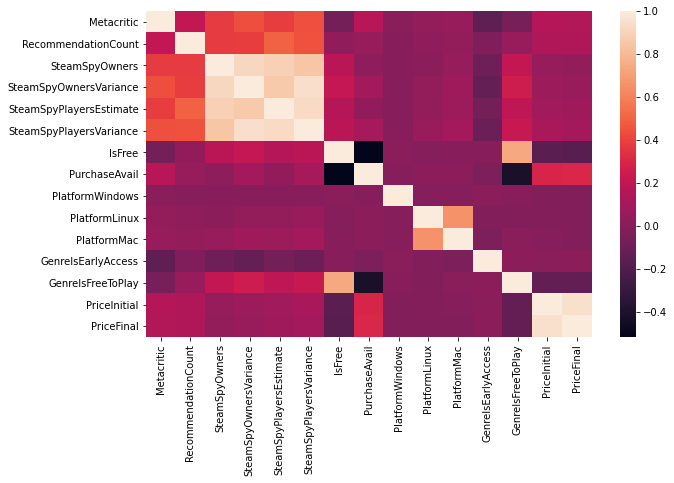

In [85]:
#correlation heatmap
#the darker the color the worse the correlation
corr_heatmap = sns.heatmap(corr)
plt.show()
fig = corr_heatmap.get_figure()
fig.savefig('figures/corr_heatmap.png')

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6

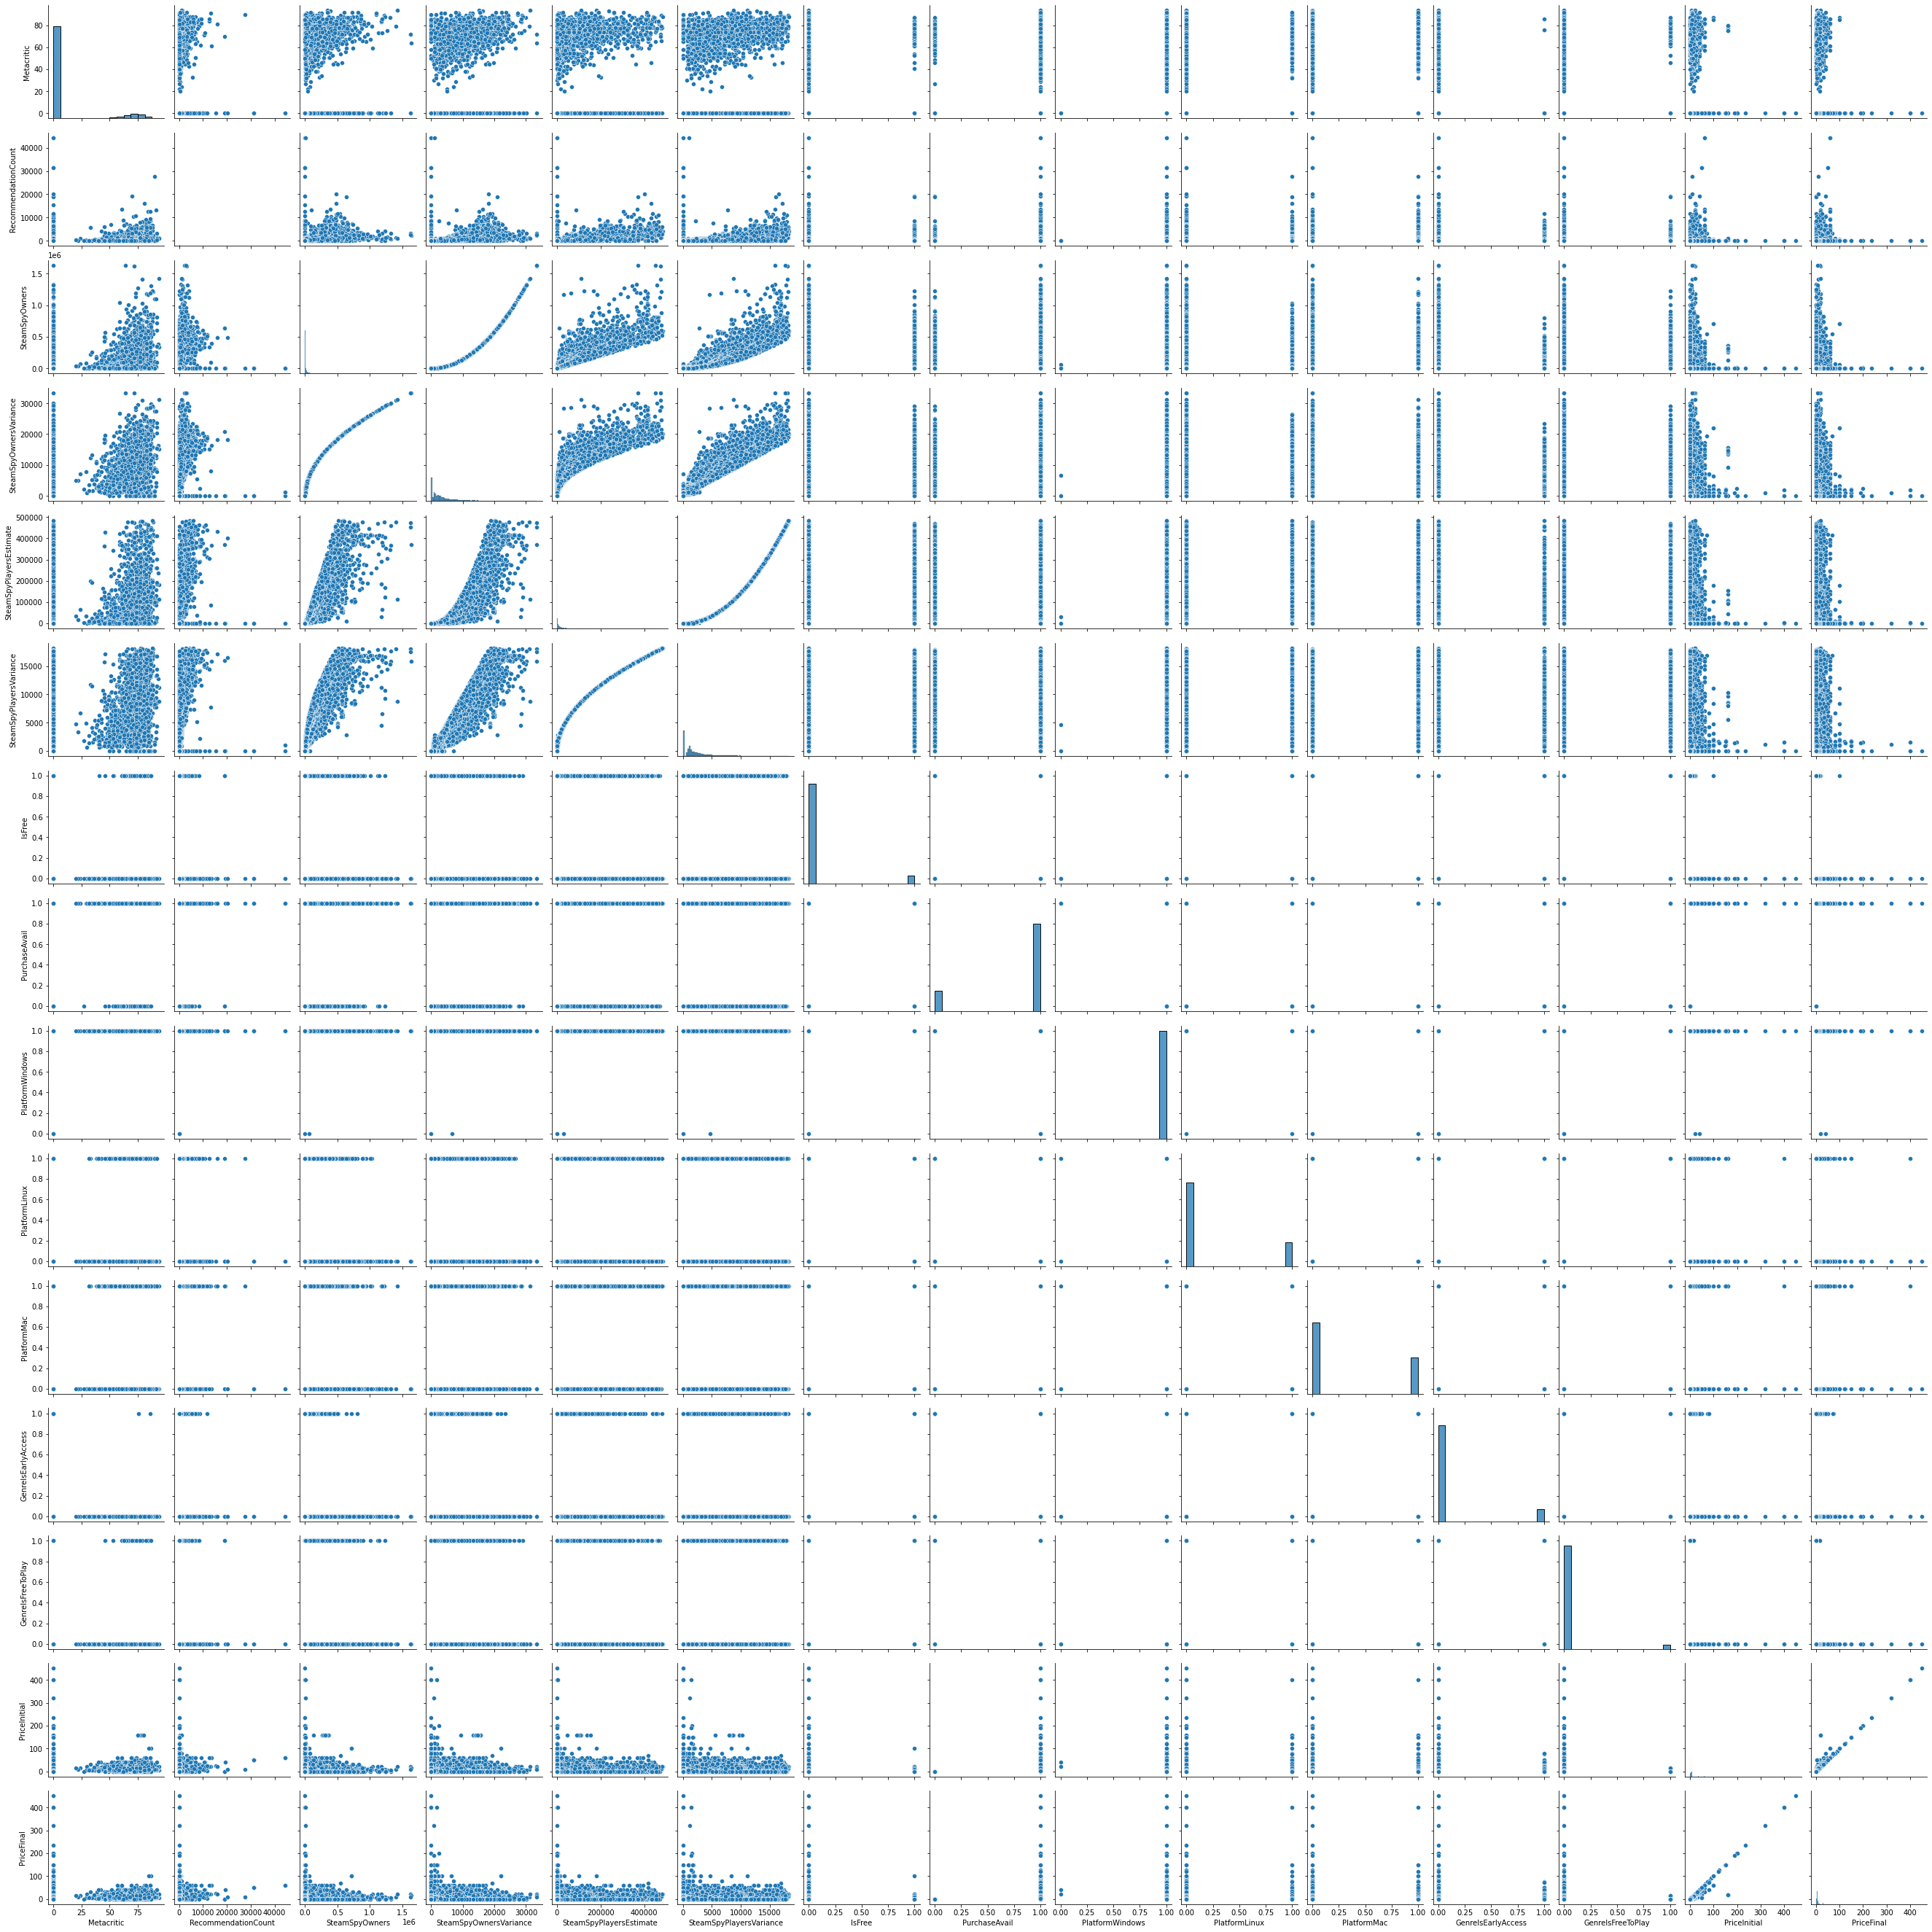

In [69]:
#reference scatter matrix.  It looks better on the jpg than on Jupyter notebook
scatter_matrix = sns.pairplot(df_sales[['Metacritic', 'RecommendationCount', 'SteamSpyOwners','SteamSpyOwnersVariance', 'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'IsFree', 'PurchaseAvail', 'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'GenreIsEarlyAccess', 'GenreIsFreeToPlay', 'PriceInitial', 'PriceFinal']])
plt.savefig('sales_scatter.jpg') #saving plot since this takes awhile to run
# the warning given is just numpy converting the booleans to [0,1]

In [70]:
# fit regression model with statsmodel
boxleiter = sm.ols(formula="SteamSpyOwners ~ RecommendationCount", data=df_sales).fit()
boxleiter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SteamSpyOwners   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     2160.
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:54:48   Log-Likelihood:            -1.6832e+05
No. Observations:               12790   AIC:                         3.366e+05
Df Residuals:                   12788   BIC:                         3.367e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            4.658e+04   1145.007     40.678      0.000    4.43e+04    4.88e+04
RecommendationCount    40.9839      0.882     46.472      0.000      39.255      42.713
==============================================================================
Omnibus:                     9926.679   Durbin-Watson:                   1.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           803326.461
Skew:                           3.123   Prob(JB):                         0.00
Kurtosis:                      41.320   Cond. No.                     1.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'Intercept': 46576.38971946707, 'RecommendationCount': 40.983893334929554}


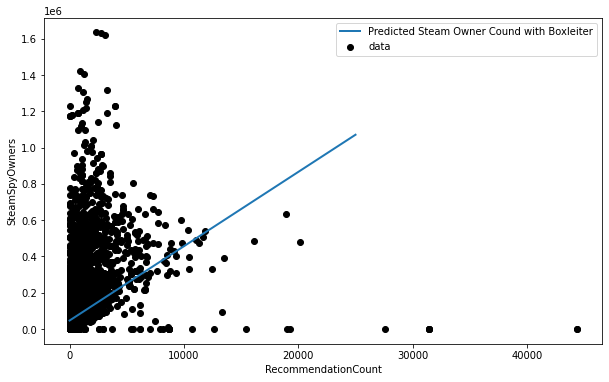

In [88]:
par1 = dict(boxleiter.params)

plt.scatter(df_sales['RecommendationCount'],df_sales['SteamSpyOwners'],color='black',label="data")
x = np.linspace(0, 25000)
y1 = par1["Intercept"] + par1['RecommendationCount']*x

plt.plot(x,y1,label="Predicted Steam Owner Cound with Boxleiter",linewidth=2)
plt.legend()
plt.xlabel('RecommendationCount'); plt.ylabel('SteamSpyOwners')
#plt.ylim((0,50))
#plt.show()
plt.savefig('figures/boxleitter.png')
print(par1)


## Beat the Boxleiter number




[12788, 4289, 2865]


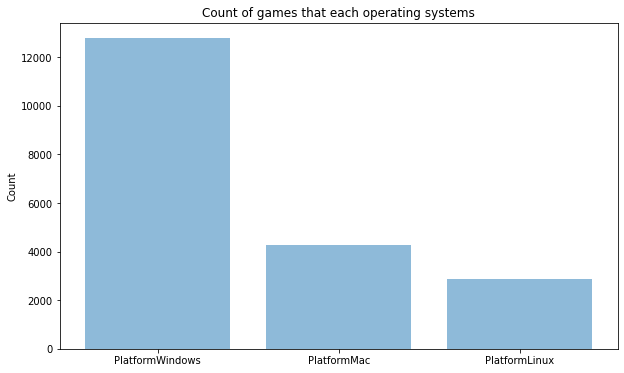

In [87]:
#bar chart
windows_count = df_sales['PlatformWindows'].sum()
mac_count = df_sales['PlatformMac'].sum()
linux_count = df_sales['PlatformLinux'].sum()
x = ('PlatformWindows', 'PlatformMac', 'PlatformLinux')
x_pos = np.arange(len(x))
counts = [windows_count,mac_count, linux_count]
print(counts)

plt.bar(x_pos,counts, align='center', alpha=0.5)
plt.xticks(x_pos, x)
plt.ylabel('Count')
plt.title('Count of games that each operating systems')
#plt.show()
plt.savefig('figures/platforms.png')


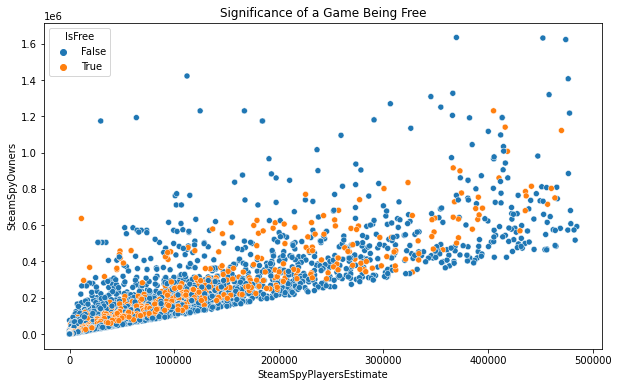

In [73]:
#do something with scatterplots and the booleans just to see if there is something there
sns.scatterplot(data=df_sales, x="SteamSpyPlayersEstimate", y="SteamSpyOwners", hue='IsFree')
plt.xlabel('SteamSpyPlayersEstimate')
plt.ylabel('SteamSpyOwners')
plt.title('Significance of a Game Being Free')
plt.savefig('figures/isFree.png')

Text(0.5, 1.0, 'Significance of a Game Costing Money')

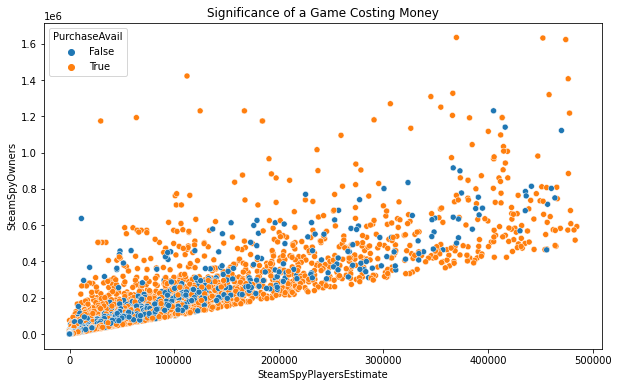

In [74]:
sns.scatterplot(data=df_sales, x="SteamSpyPlayersEstimate", y="SteamSpyOwners", hue='PurchaseAvail')
plt.xlabel('SteamSpyPlayersEstimate')
plt.ylabel('SteamSpyOwners')
plt.title('Significance of a Game Costing Money')

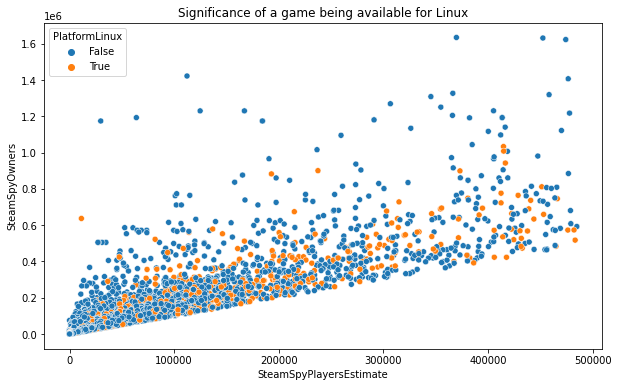

In [75]:
sns.scatterplot(data=df_sales, x="SteamSpyPlayersEstimate", y="SteamSpyOwners", hue='PlatformLinux')
plt.xlabel('SteamSpyPlayersEstimate')
plt.ylabel('SteamSpyOwners')
plt.title('Significance of a game being available for Linux')
plt.savefig('figures/linux.png')

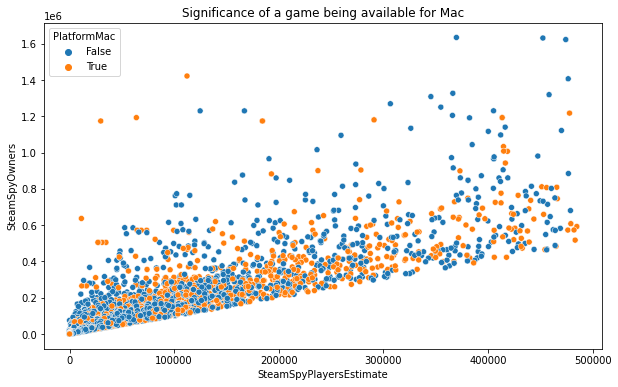

In [76]:
sns.scatterplot(data=df_sales, x="SteamSpyPlayersEstimate", y="SteamSpyOwners", hue='PlatformMac')
plt.xlabel('SteamSpyPlayersEstimate')
plt.ylabel('SteamSpyOwners')
plt.title('Significance of a game being available for Mac')
plt.savefig('figures/mac.png')

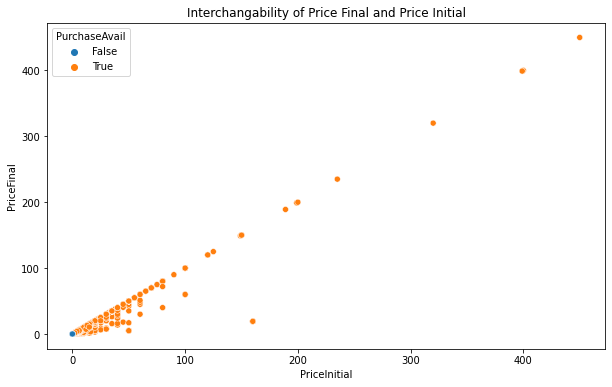

In [77]:
#just to show that PriceInitial and PriceFinal can be used interchangably
sns.scatterplot(data=df_sales, x="PriceInitial", y="PriceFinal", hue='PurchaseAvail')
plt.xlabel('PriceInitial')
plt.ylabel('PriceFinal')
plt.title('Interchangability of Price Final and Price Initial')
plt.savefig('figures/price_init_final.png')

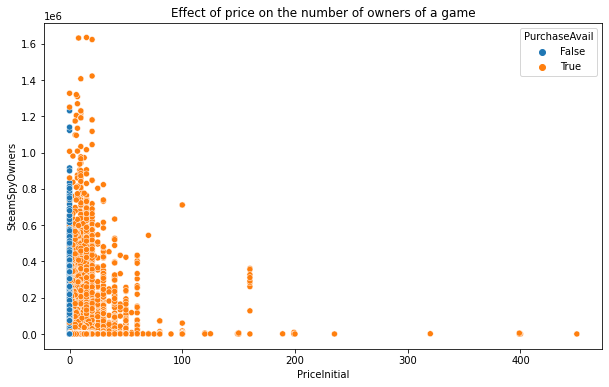

In [78]:
#just to show that PriceInitial and PriceFinal can be used interchangably
sns.scatterplot(data=df_sales, x="PriceInitial", y="SteamSpyOwners", hue='PurchaseAvail')
plt.xlabel('PriceInitial')
plt.ylabel('SteamSpyOwners')
plt.title('Effect of price on the number of owners of a game')
plt.savefig('figures/price-owners.png')

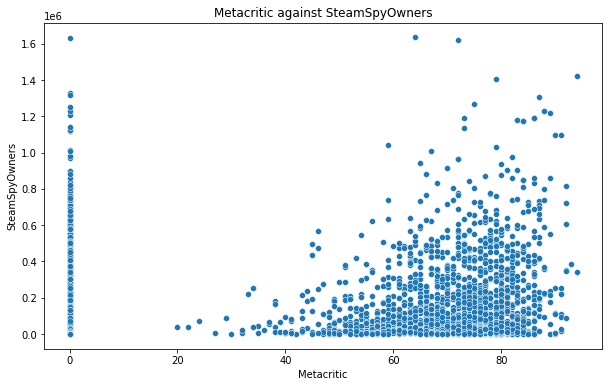

In [79]:
sns.scatterplot(data=df_sales, x="Metacritic", y="SteamSpyOwners")
plt.xlabel('Metacritic')
plt.ylabel('SteamSpyOwners')
plt.title('Metacritic against SteamSpyOwners')
plt.savefig('figures/metacritic-owners.png')

In [80]:
owners = sm.ols(formula="SteamSpyOwners ~ SteamSpyPlayersEstimate + Metacritic", data=df_sales).fit()
owners.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SteamSpyOwners   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                 2.417e+04
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:54:55   Log-Likelihood:            -1.5931e+05
No. Observations:               12790   AIC:                         3.186e+05
Df Residuals:                   12787   BIC:                         3.186e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                5203.4915    616.594      8.439      0.000    3994.875    6412.108
SteamSpyPlayersEstimate     1.6966      0.009    198.610      0.000       1.680       1.713
Metacritic                240.6899     23.511     10.237      0.000     194.605     286.774
==============================================================================
Omnibus:                    15204.131   Durbin-Watson:                   1.449
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3148339.357
Skew:                           6.130   Prob(JB):                         0.00
Kurtosis:                      78.878   Cond. No.                     8.54e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'Intercept': 5203.491520350112, 'SteamSpyPlayersEstimate': 1.696585614779159, 'Metacritic': 240.68987488995768}


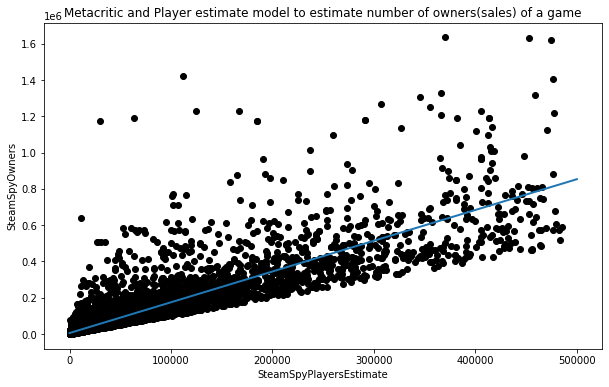

In [89]:
par = dict(owners.params)

plt.scatter(df_sales['SteamSpyPlayersEstimate'],df_sales['SteamSpyOwners'],color='black',label="data")
x = np.linspace(0, 500000)
y1 = par["Intercept"] + par['SteamSpyPlayersEstimate']*x

plt.plot(x,y1,linewidth=2)
plt.xlabel('SteamSpyPlayersEstimate'); plt.ylabel('SteamSpyOwners')
plt.title("Metacritic and Player estimate model to estimate number of owners(sales) of a game")
#plt.show()
plt.savefig('figures/our-model.png')
print(par)

In [48]:
#Cross-validation method
X = df_sales[['SteamSpyPlayersEstimate', 'Metacritic']]
# the two following might be autocorrelated to each other.
#'GaragCap': # of parking spots
#'PkgSpacs': # of parking spaces
Y = df_sales['SteamSpyOwners']
x_train, x_test, y_train, y_test = train_test_split(X, Y)
regression = linear_model.LinearRegression()
regression.fit(x_train, y_train)
y_pred = regression.predict(x_test)
print("x_train length=",len(x_train), " , x_test length=",len(x_test), " , y_train length=",len(y_train), " , y_test length=",len(y_test))
regression.score(x_test, y_test) # how well is the performance when predicting how many people would own the game

x_train length= 9592  , x_test length= 3198  , y_train length= 9592  , y_test length= 3198


0.8037870437868219

In [49]:
# Ridge and Lasso regression imports
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale 
from sklearn.metrics import mean_squared_error

In [55]:
ridge_regression = Ridge(alpha=10, fit_intercept=True)
ridge_regression.fit(x_train, y_train) # We don't need to standardize the predictors here with scale(x_train)

print('Ridge regression model:\n {} + {}^T . x'.format(ridge_regression.intercept_, ridge_regression.coef_))
print('Train R^2: {}, test R^2: {}'.format(ridge_regression.score(x_train,y_train),
                                           ridge_regression.score(x_test, y_test)))

Ridge regression model:
 5511.092667006145 + [  1.68488147 237.70771298]^T . x
Train R^2: 0.7860435835754369, test R^2: 0.8037870434784674


In [54]:
lasso_regression = Lasso(alpha=1, fit_intercept=True, max_iter=10000)
lasso_regression.fit(x_train, y_train)

print('Lasso regression model:\n {} + {}^T . x'.format(lasso_regression.intercept_, lasso_regression.coef_))
print('Train R^2: {}, test R^2: {}'.format(lasso_regression.score(x_train, y_train), 
                                           lasso_regression.score(x_test, y_test)))

Lasso regression model:
 5511.101129555944 + [  1.68488166 237.70634985]^T . x
Train R^2: 0.7860435835753429, test R^2: 0.803787042540323


Sources:

[1] https://newsletter.gamediscover.co/p/how-that-game-sold-on-steam-using

[2] http://greyaliengames.com/blog/how-to-estimate-how-many-sales-a-steam-game-has-made/

[3] https://www.gamasutra.com/blogs/JakeBirkett/20180504/317366/Using_Steam_reviews_to_estimate_sales.php